## Extract snow depth along a trajectory __UNDER CONSTRUCTION__

I use an icetrack extracted using the [NSIDC ice tracking tool](http://icemotion.labs.nsidc.org/SITU/#).  The tool outputs a csv file.  This is easily read using `pandas`.  I want a dataframe indexed by date.  I use `parse_dates={'time': ['year','month','day'}` and `index_col='time'` to create a date index.  I only need latitude and longitude so I use `usecols` to extract latitude and longitude.  However, because `year`, `month` and `day` are used to generate the date index, these columns must be included in usecols.

In [39]:
import pandas as pd

trackfile = '../Data/icetracks.20040403.csv'

In [54]:
df = pd.read_csv(trackfile, header=0, parse_dates={'time': ['year', 'month', 'day']}, index_col='time', usecols=['lat', 'lon', 'year', 'month', 'day'])
df.head()

,lat,lon
time,,
2000-04-03,84.50810,10.619687
2000-03-27,84.69821,12.388343
2000-03-20,85.18298,12.508698
2000-03-13,85.49818,16.981724
2000-03-06,85.37117,22.402065


The snow depth data are on a grid in the NSIDC North Polar Stereo projection.  So the latitude and longitude coordinates need to be transformed to projected `(x,y)` coordinates.  `cartopy.crs.Projection` classes have a `transform_points` method that can do this easily.  The [NSIDC North Polar Stereographic Projection](https://nsidc.org/data/polar-stereo/ps_grids.html) is different from the standard `cartopy.crs.NorthPolarStereo` projection so a non-standard projection needs to be defined. 

In [55]:
import cartopy.crs as ccrs

In [67]:
HughsEllipsoid = ccrs.Globe(semimajor_axis=6378273., semiminor_axis=6356889.449)
NSIDC_NorthPolarStereo = ccrs.Stereographic(central_latitude=90., central_longitude=-45., true_scale_latitude=70., globe=HughsEllipsoid)

In [72]:
xyz = NSIDC_NorthPolarStereo.transform_points(ccrs.PlateCarree(), df.lon.values, df.lat.values)
x = xyz[:,0]
y = xyz[:,1]

In [73]:
import matplotlib.pyplot as plt

/home/apbarret/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


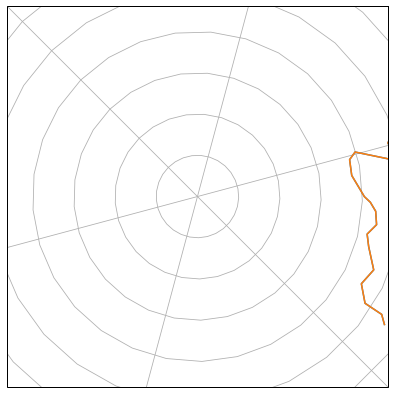

In [88]:
# This needs to be fixed
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_NorthPolarStereo)
ax.set_extent([-500000, 500000, -500000, 500000], NSIDC_NorthPolarStereo)
ax.coastlines()
ax.gridlines()
ax.plot(x, y, transform=NSIDC_NorthPolarStereo)
ax.plot(df.lon.values, df.lat.values, transform=ccrs.PlateCarree())

The data are weekly and need to be interpolated to daily to extract the data.  __TBD__